## Objectives

1.- Predict ad/absorption energies (Eads) of atomic C on transition metal surfaces using electronic and geometric features of such surfaces.

2.- Identify the most relevant features describing ad/absorption energies.

3.- Investigate how the most relevant features identified at (2) are clustered.

4.- Project the clusters into the ad/absorption energy (Eads) versus C height (h) 2-dimensional space.

## Importing Libraries

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import sklearn
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error

# Here, a seed is chosen to ensure that each run produces the same results. 
# Everytime a random number is needed n_rand is used.
n_rand = 95

sklearn.__version__ # Checking the sklearn version used in this notebook.

'1.0.1'

## Defining a Function to Calculate Learning Curves

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = -1, train_sizes = np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(8,6))
    plt.title(title, fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Set Size", fontsize=18)
    plt.ylabel("MAE (kJ/mol)",fontsize=18)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_absolute_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    train_scores_q25 = np.quantile(train_scores,0.25, axis=1)
    train_scores_q50 = np.quantile(train_scores,0.50, axis=1)
    train_scores_q75 = np.quantile(train_scores, 0.75, axis=1)
    
    test_scores_q25 = np.quantile(test_scores,0.25, axis=1)
    test_scores_q50 = np.quantile(test_scores,0.50, axis=1)
    test_scores_q75 = np.quantile(test_scores, 0.75, axis=1)
    
    plt.grid(color='gray', linestyle='--', linewidth=0.3, zorder=0)

    plt.tick_params(axis='both', direction = 'out')
    
    plt.fill_between(train_sizes, -1*train_scores_q25,
                    -1*train_scores_q75, alpha=0.3,
                     color="b")
    plt.fill_between(train_sizes, -1*test_scores_q25,
                     -1*test_scores_q75, alpha=0.3, color="g")
    plt.plot(train_sizes, -train_scores_q50, '-', color="b",
             label="Train MAE")
    plt.plot(train_sizes, -test_scores_q50, '-', color="g",
             label="Test MAE")
  
    plt.legend(loc="best", fontsize=16)
    return plt

## Reading, Encoding, and Organizing Data

In [3]:
data = pd.read_csv("data.csv", sep=';') # Reading data from the .csv file.
columns = [0, 3, 11, 12, 14, 16, 17, 18]
data.drop(data.columns[columns],axis=1,inplace=True) # Eliminating unnecessary columns.

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
data = ct.fit_transform(data) # Enconding categorical features as vectors.
data = DataFrame(data)
data.columns = ["bcc", "fcc", "hcp", "distance", "nd", "cn sur", "Ed", "Edw", "Eu", "SE", "WF", "CNsite", "Eads"]
pd.set_option("display.max_columns", None)

i=0 # Eliminating unnecessary rows
while data.shape[0] > 81:
    data.drop([data.index[i] , data.index[i+1], data.index[i+2]], inplace=True)
    i = i + 1
data.reset_index(inplace=True)
del data["index"]

data.head()

,bcc,fcc,hcp,distance,nd,cn sur,Ed,Edw,Eu,SE,WF,CNsite,Eads
0,0.0,0.0,1.0,319.7,2.0,9.0,3.00,12.26,4.60,1.59,4.95,6.0,-887.0
1,0.0,0.0,1.0,319.7,2.0,8.0,3.04,12.58,-0.38,1.63,3.15,5.0,-805.0
2,0.0,0.0,1.0,319.7,2.0,7.0,2.41,10.86,0.08,1.64,3.38,6.0,-930.0
3,0.0,0.0,1.0,289.0,10.0,9.0,-7.21,-2.04,-6.92,0.35,4.12,6.0,-461.0
4,0.0,0.0,1.0,289.0,10.0,8.0,-6.97,-2.43,-6.80,0.57,2.52,5.0,-421.0


## Defining X, Y, and the Cross-Validation Method

In [4]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# X contains a 2-dimensional matrix with all the features. Y contains the Eads vector.
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Shuffle Split works better since the dataset is very small and results are susceptible to how is the dataset split.
cv = ShuffleSplit(n_splits=20, train_size = 0.8, test_size=0.2, random_state=n_rand)

## Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression # Evaluating a linear regression in terms of test MAE.

estimator = LinearRegression()
scores = cross_val_score(estimator = estimator, X = X, y = y, scoring = "neg_mean_absolute_error", cv = cv)

print("MAE: {:.1f}".format(-scores.mean()), u"\u00B1", "{:.1f}".format(scores.std()))

MAE: 66.6 ± 12.4


## Decision Tree Regressor

In [6]:
from sklearn.tree import DecisionTreeRegressor # Evaluating a decision tree regressor in terms of test MAE.

estimator = DecisionTreeRegressor(random_state=n_rand)
scores = cross_val_score(estimator = estimator, X = X, y = y, scoring = "neg_mean_absolute_error", cv = cv)

print("MAE: {:.1f}".format(-scores.mean()), u"\u00B1", "{:.1f}".format(scores.std()))

MAE: 49.5 ± 8.6


## Random Forest Regressor

In [7]:
from sklearn.ensemble import RandomForestRegressor # Evaluating a random forest regressor in terms of test MAE.

estimator = RandomForestRegressor(n_estimators=30, random_state=n_rand)
scores = cross_val_score(estimator = estimator, X = X, y = y, scoring = "neg_mean_absolute_error", cv = cv)

print("MAE: {:.1f}".format(-scores.mean()), u"\u00B1", "{:.1f}".format(scores.std()))

# Random Forest is the best performing regressor. From hereon, we improve/tune/optimize the method.

MAE: 43.3 ± 8.7


## Removing Unnecessary Features

In [8]:
# Here, the leave-one-out procedure is used to eliminate the non (or less) relevant features.

estimator = RandomForestRegressor(n_estimators=30, random_state=n_rand)

predictors = ["Ed", "SE", "CNsite"] # One can add/remove features by including them (or not) in this list.
X = DataFrame(data[predictors])
y = DataFrame(data["Eads"])

y = np.array(y)
y = y.ravel()

scores = cross_val_score(estimator = estimator, X = X, y = y, scoring = "neg_mean_absolute_error", cv = cv)

print("MAE: {:.1f}".format(-scores.mean()), u"\u00B1", "{:.1f}".format(scores.std()))

MAE: 40.5 ± 9.3


In [9]:
# Feature importances are a good way of assesing the relevance of each feature in the model.
# Removing the least relevant feature and assesing the impact on the test MAE is the optimal way to proceed.

# The most relevant features for the prediction of ad/absorption energies are Ed, SE, and CNsite.

results = cross_validate(estimator, X, y, scoring = "neg_mean_absolute_error", cv = cv, return_estimator = True)
importances = []
for model in results['estimator']:
    importances.append(model.feature_importances_)
mean = sum(importances) / len(importances)
print("Mean Feature Importances:")
print("")
for i,v in enumerate(mean):
     print('%s: %.3f' % (predictors[i],v))

Mean Feature Importances:

Ed: 0.813
SE: 0.095
CNsite: 0.092


## Tunning Hyperparameters

In [10]:
# Here, the best hyperparameters for our model are investigated.

from sklearn.model_selection import GridSearchCV

# A grid of parameters is built.
param_grid = [
        {'n_estimators': [30, 50, 70], 'max_features': [None, 1, 2, 3]},
        {'bootstrap': [False], 'n_estimators': [30, 50, 70], 'max_features': [None, 1, 2, 3]},
  ]

# GridSearch finds the best combination of parameters, evaluating each of them through the chosen CV method.
grid_search = GridSearchCV(estimator, param_grid, cv = cv,
                           scoring = "neg_mean_absolute_error", return_train_score = True, n_jobs = -1)
grid_search.fit(X, y)

estimator = grid_search.best_estimator_

print("")
print("Best Parameters:", grid_search.best_params_)
print("")
print("---------------------------------------------")

# Train and test MAEs are printed.
results = cross_validate(estimator, X, y, scoring = "neg_mean_absolute_error", cv = cv, return_estimator = True, return_train_score = True)
scores_test = results["test_score"]
scores_train = results["train_score"]
print("")
print("Final Test MAE: {:.1f}".format(-scores_test.mean()), u"\u00B1", "{:.1f}".format(scores_test.std()))
print("Final Train MAE {:.1f}".format(-scores_train.mean()), u"\u00B1", "{:.1f}".format(scores_train.std()))
print("")
print("---------------------------------------------")

# Feature importances are also printed in order to undertand which are the most relevant features for our model.
importances = []
for model in results['estimator']:
    importances.append(model.feature_importances_)
mean = sum(importances) / len(importances)
print("")
print("Mean Feature Importances:")
print("")
for i,v in enumerate(mean):
     print('%s: %.3f' % (predictors[i],v))


Best Parameters: {'max_features': 2, 'n_estimators': 50}

---------------------------------------------

Final Test MAE: 39.0 ± 8.9
Final Train MAE 13.7 ± 0.9

---------------------------------------------

Mean Feature Importances:

Ed: 0.609
SE: 0.312
CNsite: 0.079


## Learning Curve of the Final Model

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

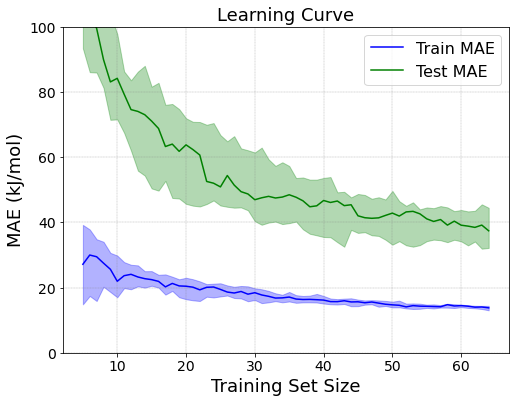

In [11]:
# Here, the learning curve of the best model is shown.
# It is interesting to see if the error has converged in terms of the number of samples in the training set.
# It looks like the error is not fully converge. Hence, more training set samples would improve the model.

import matplotlib.pyplot as plt
%matplotlib inline

title = 'Learning Curve'
plot_learning_curve(estimator, title, X, y, ylim = (0, 100.), cv = cv, train_sizes = range(5,65))

## K-Means Clustering of the Most Relevant Features

In [12]:
data = pd.read_csv("data.csv", sep=';') # Reading data from the .csv file.
columns = [0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 14, 16, 17]
data.drop(data.columns[columns],axis=1,inplace=True) # Eliminating unnecessary columns.

data.columns = ["Ed", "SE", "CNsite", "Eads", "h"]

i=0 # Eliminating unnecessary rows
while data.shape[0] > 81:
    data.drop([data.index[i] , data.index[i+1], data.index[i+2]], inplace=True)
    i = i + 1
data.reset_index(inplace=True)
del data["index"]

data["Eads"] = data["Eads"]*-1 # Turning ad/absorption energies positive to simplify visulization/interpretation.

data_safe = data.copy() # Recovering the original dataframe.

columns = [3,4]
data.drop(data.columns[columns],axis=1,inplace=True) # Eliminating unnecessary columns.

## Data Visualization

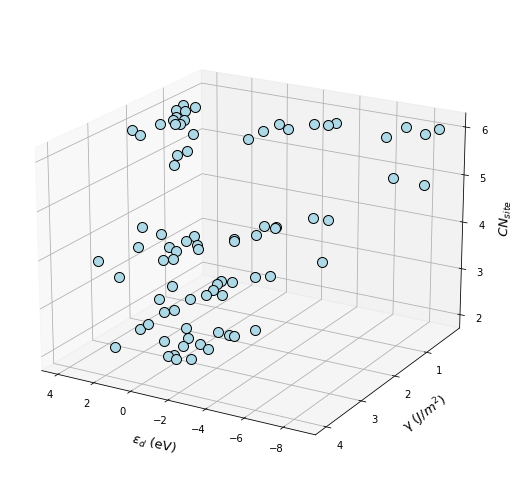

In [13]:
# The data that needs to be clustered is visualized.

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
ax.scatter3D(data["Ed"], data["SE"], data["CNsite"], facecolor = 'lightblue', 
    edgecolor = 'black', s = 100, depthshade = False)

ax.set_xlabel('$ε_d$ (eV)', fontsize = 13, labelpad = 10)
ax.set_ylabel('γ $(J/m^2$)', fontsize = 13, labelpad = 10)
ax.set_zlabel('$CN_{site}$', fontsize = 13, labelpad = 6)

ax.set_yticks([1, 2, 3, 4])
ax.set_zticks([2, 3, 4, 5, 6])

ax.view_init(elev=20, azim=120)

plt.tight_layout()

plt.show()

## Data Normalization

In [14]:
# Data has to be normalized, since K-Means uses Euclidean distances to measure how "far" data points are.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

## Determining the Optimal Number of Clusters

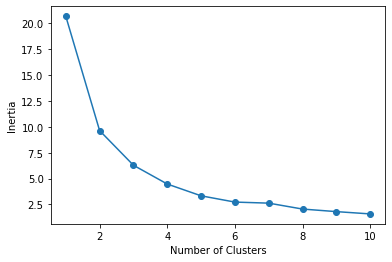

In [15]:
# The number of clusters is an input of the algorithm. Hence, it needs to be determined beforehand.
# Here, the elbow method is used to select the number of clusters. It looks like 3 clusters is the optimal number.

from sklearn.cluster import KMeans
inertia = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(data)
    inertia.append(km.inertia_)

inertia = np.array(inertia)
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

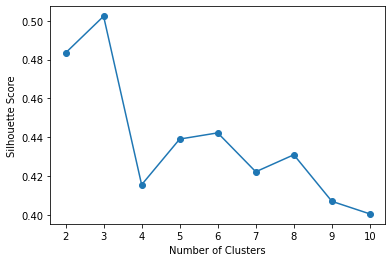

In [16]:
# The Silhouette score is also used to assure that 3 is indeed the optimal number of clusters.

from sklearn.metrics import silhouette_score

sil = []
kmax = 10

for i in range(2, kmax+1):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(data)
    labels = km.labels_
    sil.append(silhouette_score(data, labels, metric = 'euclidean'))

plt.plot(range(2, 11), sil, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## Fit

In [17]:
# Fitting the method.

km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(data)

## Results Visualization

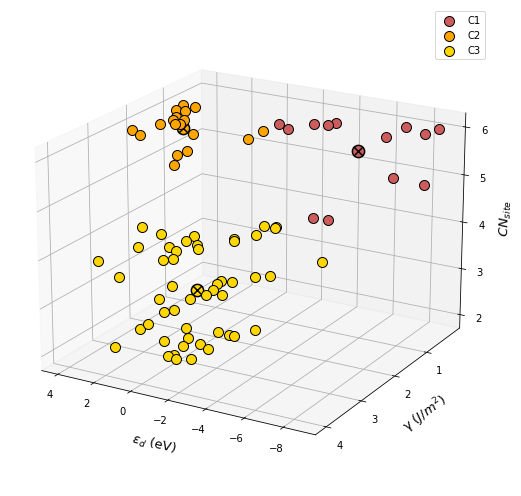

In [18]:
# Here, data is visualized coloured according to which cluster does each of the data points belong to.

data = data_safe.copy() # Recovering the original dataframe.
data["Cluster"] = y_km # Adding a new column indicating to which cluster does each data row belong to.

# Creating one dataframe for each cluster.
C1 = data.loc[data['Cluster'] == 0]
C2 = data.loc[data['Cluster'] == 1]
C3 = data.loc[data['Cluster'] == 2]

# The center of each of the clusters is shown with a circle of the corresponding colour with a black X mark inside.
centers = scaler.inverse_transform(km.cluster_centers_)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
ax.scatter3D(C1["Ed"], C1["SE"], C1["CNsite"], facecolor = '#FFD700', edgecolor = 'black', s = 100, depthshade = False, label = "C3")
ax.scatter3D(C2["Ed"], C2["SE"], C2["CNsite"], facecolor = '#CD5C5C', edgecolor = 'black', s = 100, depthshade = False, label = "C1")
ax.scatter3D(C3["Ed"], C3["SE"], C3["CNsite"], facecolor = '#FFA500', edgecolor = 'black', s = 100, depthshade = False, label = "C2")
ax.scatter3D(centers[0,0], centers[0,1], centers[0,2], facecolor = '#FFD700', edgecolor = 'black', lw = 1.5, s = 150, depthshade = False)
ax.scatter3D(centers[1,0], centers[1,1], centers[1,2], facecolor = '#CD5C5C', edgecolor = 'black', lw = 1.5, s = 150, depthshade = False)
ax.scatter3D(centers[2,0], centers[2,1], centers[2,2], facecolor = '#FFA500', edgecolor = 'black', lw = 1.5, s = 150, depthshade = False)
ax.scatter3D(centers[0,0], centers[0,1], centers[0,2], marker = 'x', lw = 1.5, color = 'black', s = 80, depthshade = False)
ax.scatter3D(centers[1,0], centers[1,1], centers[1,2], marker = 'x', lw = 1.5, color = 'black', s = 80, depthshade = False)
ax.scatter3D(centers[2,0], centers[2,1], centers[2,2], marker = 'x', lw = 1.5, color = 'black', s = 80, depthshade = False)


ax.set_xlabel('$ε_d$ (eV)', fontsize = 13, labelpad = 10)
ax.set_ylabel('γ $(J/m^2$)', fontsize = 13, labelpad = 10)
ax.set_zlabel('$CN_{site}$', fontsize = 13, labelpad = 6)

ax.set_yticks([1, 2, 3, 4])
ax.set_zticks([2, 3, 4, 5, 6])

ax.view_init(elev=20, azim=120)

handles,labels = ax.get_legend_handles_labels()

handles = [handles[1], handles[2], handles[0]]
labels = [labels[1], labels[2], labels[0]]

ax.legend(handles,labels,loc='best')

plt.tight_layout()

plt.show()

## Cluster Centers

In [19]:
# Obtaining the centers of each cluster and inverse transforming them to the original scale.
centers = scaler.inverse_transform(km.cluster_centers_)

elements = ["Ed", "SE", "CNsite"]

# Printing the centers' values with the corresponding standard deviation.
c = 1
for array in centers:
    print("Cluster", c)
    print("-------------------")
    if c == 1:
        for i,v in enumerate(array):
            print(elements[i], "{:.1f}".format(v), u"\u00B1", "{:.1f}".format(C1[elements[i]].std()))
    elif c == 2:
        for i,v in enumerate(array):
            print(elements[i], "{:.1f}".format(v), u"\u00B1", "{:.1f}".format(C2[elements[i]].std()))
    elif c == 3:
        for i,v in enumerate(array):
            print(elements[i], "{:.1f}".format(v), u"\u00B1", "{:.1f}".format(C3[elements[i]].std()))
    elif c == 4:
        for i,v in enumerate(array):
            print(elements[i], "{:.1f}".format(v), u"\u00B1", "{:.1f}".format(C4[elements[i]].std()))
    print("")
    c = c + 1

# Importantly, we observe that, even when accounting for the standard deviation,
# the values of the features do not overlap between the different clusters.

Cluster 1
-------------------
Ed -0.1 ± 1.7
SE 2.6 ± 0.7
CNsite 3.0 ± 0.9

Cluster 2
-------------------
Ed -5.4 ± 2.5
SE 0.7 ± 0.3
CNsite 5.5 ± 0.8

Cluster 3
-------------------
Ed 2.5 ± 1.7
SE 1.6 ± 0.5
CNsite 5.8 ± 0.4



## Projection in the 2-Dimensional Eads vs. h Space.

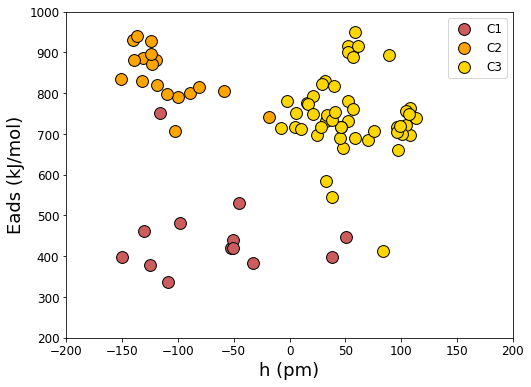

In [20]:
# Using the clustering done for the 3-dimensional feature space, we project the data in the Eads vs h 2-dimensional
# space.

plt.figure(figsize=(8,6))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("h (pm)", fontsize=18)
plt.ylabel("Eads (kJ/mol)",fontsize=18)

plt.xlim([-200,200])
plt.ylim([200,1000])

plt.scatter(
    C2["h"], C2["Eads"],
    s=140, c='#CD5C5C',
    marker='o', edgecolor='black',
    label='C1'
)

plt.scatter(
    C3["h"], C3["Eads"],
    s=140, c='#FFA500',
    marker='o', edgecolor='black',
    label='C2'
)

plt.scatter(
    C1["h"], C1["Eads"],
    s=140, c='#FFD700',
    marker='o', edgecolor='black',
    label='C3'
)

plt.legend(loc="best", fontsize=12)

plt.show()

# We know have identified 3 different clusters in the Eads vs. h space, hence, 3 different atomic C behaviours
# when interacting with TM surfaces: C1 (weak interaction and negative h's), C2 (strong interaction and negative h's),
# and C3 (strong interaction and positive h's).

# Moreover, we calculated the features' values that would lead a certain TM surface into belonging in
# one particular cluster, showing one of the three different behaviours towards atomic C.

## Conclusions

1.- We trained a random forest regression model to predict atomic C ad/absoprtion energies (Eads) on TM surfaces using only 3 features.

2.- We identified Ed, SE, and CNsite, as the most relevant features describing Eads.

3.- The K-Means clustering of the 3-dimensional feature space, and its projection into the Eads vs. h 2-dimensional space, allowed us to identify 3 different atomic C behaviors when interacting with TM surfaces.

4.- Knowing the centers' values for each of the clusters allows us to categorize an hypothetic new TM surface into one of the three different clusters, hence predicting its behaviour towards atomic C.